**Step 1**: Setting up Google Colab

In [3]:
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#download the dataset
download = drive.CreateFile({'id': '11nuXjhsfyAuZUfKGIiB3_aG7T4fZQQd_'})

In [7]:
download.GetContentFile('train_set.zip')
!unzip train_set.zip

Archive:  train_set.zip
replace train_set/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/train_set/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: o
error:  invalid response [o]
replace __MACOSX/train_set/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train_set/label.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/train_set/._label.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Step 2** : Import the libraries we’ll need during our model building phase.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

**Step 3**: Load and reprocess the training image/label dataset

In [0]:
train = pd.read_csv('train_set/label.csv')

In [6]:
# We have RGB images, we should set grayscale as False
train_image = []
for i in tqdm(range(train.shape[0])):
    img = image.load_img('train_set/HR/'+'img_'+train['Image'][i], target_size=(28,28,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 1500/1500 [00:10<00:00, 142.37it/s]


As it is a multi-class classification problem (3 classes), we will one-hot encode the target variable.

In [0]:
y=train['Label'].values
y = to_categorical(y)

**Step 4**: Creating a validation set from the training data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

**VGG19**
A common and highly effective approach to deep learning on small image datasets is to use a pretrained network. A pretrained network is a saved network that was previously trained on a large dataset, typically on a large-scale image-classification task. If this original dataset is large enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model of the visual world, and hence its features can prove useful for many different computer-vision problems, even though these new problems may involve completely different classes than those of the original task.

In [30]:
# Resize the images as 150 * 150 as required by VGG19
from keras.preprocessing.image import img_to_array, array_to_img

X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_train])
X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((150,150))) for im in X_test])

# Display the new shape
X_train.shape, X_test.shape

((1200, 150, 150, 3), (300, 150, 150, 3))

In [0]:
# Normalise the data and change data type
X_train = X_train.astype('float32')
X_train /= 255

X_test = X_test.astype('float32')
X_test /= 255

In [33]:
from sklearn.model_selection import train_test_split

# Here I split original training data to sub-training (80%) and validation data (20%)
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

# Check the data size whether it is as per tensorflow and VGG19 requirement
X_train1.shape, X_val.shape, y_train1.shape, y_val.shape

((960, 150, 150, 3), (240, 150, 150, 3), (960, 3), (240, 3))

In [12]:
from keras.applications import VGG19

# Create the base model of VGG19
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape = (150, 150, 3), classes = 3)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [13]:
vgg19.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

**step 5**: Extract features.

**Feature Extraction**
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

CNNs used for image classification comprise two parts: they start with a series of pooling and convolution layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data through it, and training a new classifier on top of the output.

In [0]:
from keras.applications.vgg19 import preprocess_input

# Preprocessing the input 
X_train1 = preprocess_input(X_train1)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [35]:
# Extracting features
train_features = vgg19.predict(np.array(X_train1),verbose=1)
test_features = vgg19.predict(np.array(X_test),verbose=1)
val_features = vgg19.predict(np.array(X_val),verbose=1)

240/240 [==============================] - 70s 292ms/step


In [0]:
# Saving the features so that they can be used for future
np.savez("train_features", train_features, y_train)
np.savez("test_features", test_features, y_test)
np.savez("val_features", val_features, y_val)

In [37]:
# Current shape of features
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(960, 4, 4, 512) 
 (300, 4, 4, 512) 
 (240, 4, 4, 512)


In [0]:
# Flatten extracted features
train_features = np.reshape(train_features, (960, 4*4*512))
test_features = np.reshape(test_features, (300, 4*4*512))
val_features = np.reshape(val_features, (240, 4*4*512))

**Step 6**: Define the model structure.

In [0]:
from keras.layers import Dense, Dropout
from keras.models import Model
from keras import models
from keras import layers
from keras import optimizers

# Add Dense and Dropout layers on top of VGG19 pre-trained
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation="softmax"))

In [0]:
import keras

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [43]:
# Train the the model
history = model.fit(train_features, y_train1,
          epochs=10,
          validation_data=(val_features, y_val))

Train on 960 samples, validate on 240 samples
Epoch 1/10
960/960 [==============================] - 3s 3ms/step - loss: 2.3581 - acc: 0.3531 - val_loss: 1.3169 - val_acc: 0.3292
Epoch 2/10
960/960 [==============================] - 2s 2ms/step - loss: 1.2581 - acc: 0.3292 - val_loss: 1.1429 - val_acc: 0.3292
Epoch 3/10
960/960 [==============================] - 2s 2ms/step - loss: 1.1192 - acc: 0.3323 - val_loss: 1.1071 - val_acc: 0.3292
Epoch 4/10
960/960 [==============================] - 2s 2ms/step - loss: 1.1141 - acc: 0.3104 - val_loss: 1.0979 - val_acc: 0.3625
Epoch 5/10
960/960 [==============================] - 2s 2ms/step - loss: 1.1002 - acc: 0.3250 - val_loss: 1.0986 - val_acc: 0.3292
Epoch 6/10
960/960 [==============================] - 2s 2ms/step - loss: 1.0985 - acc: 0.3385 - val_loss: 1.0990 - val_acc: 0.3292
Epoch 7/10
960/960 [==============================] - 2s 3ms/step - loss: 1.0983 - acc: 0.3344 - val_loss: 1.0992 - val_acc: 0.3083
Epoch 8/10
960/960 [==========

In [44]:
score = model.evaluate(test_features, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0968531942367554
Test accuracy: 0.3666666662693024


**Training CNN Models**

I will create a variety of different CNN-based classification models to evaluate performances on our training dataset. I will be building our model using the Keras framework. Here are the list of models I will try out and compare their results:

1.   CNN with 1 Convolutional Layer
2.   CNN with 3 Convolutional Layer

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

CNN with 1 Convolutional Layer

In [0]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3)))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(3, activation='softmax'))
cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 387       
Total params: 693,635
Trainable params: 693,635
Non-trainable params: 0
_________________________________________________________________


In [0]:
history1 = cnn1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.8086 - acc: 0.6492 - val_loss: 0.7413 - val_acc: 0.7267
Epoch 2/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.5277 - acc: 0.8083 - val_loss: 0.5995 - val_acc: 0.7633
Epoch 3/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.3677 - acc: 0.8808 - val_loss: 0.5954 - val_acc: 0.7767
Epoch 4/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.2923 - acc: 0.8983 - val_loss: 0.5564 - val_acc: 0.8000
Epoch 5/10
1200/1200 [==============================] - 1s 993us/step - loss: 0.2179 - acc: 0.9367 - val_loss: 0.5456 - val_acc: 0.7933
Epoch 6/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1673 - acc: 0.9475 - val_loss: 0.6301 - val_acc: 0.7967
Epoch 7/10
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1564 - acc: 0.9533 - val_loss: 0.7238 - val_acc: 0.7400
Epoch 8/10
12

In [0]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 0.5554029087225596
Test accuracy: 0.813333334128062


CNN with 3 Convolutional Layer

In [0]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,3)))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(3, activation='softmax'))
cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_32 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 3, 3, 128)         73856     
__________

In [0]:
history3 = cnn3.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Train on 1200 samples, validate on 300 samples
Epoch 1/10
1200/1200 [==============================] - 3s 2ms/step - loss: 1.0118 - acc: 0.4650 - val_loss: 0.8055 - val_acc: 0.6700
Epoch 2/10
1200/1200 [==============================] - 2s 1ms/step - loss: 0.8014 - acc: 0.6533 - val_loss: 0.6855 - val_acc: 0.7233
Epoch 3/10
1200/1200 [==============================] - 2s 1ms/step - loss: 0.6792 - acc: 0.7208 - val_loss: 0.6766 - val_acc: 0.7167
Epoch 4/10
1200/1200 [==============================] - 2s 1ms/step - loss: 0.5697 - acc: 0.7675 - val_loss: 0.5842 - val_acc: 0.7800
Epoch 5/10
1200/1200 [==============================] - 2s 1ms/step - loss: 0.5181 - acc: 0.7950 - val_loss: 0.5495 - val_acc: 0.8067
Epoch 6/10
1200/1200 [==============================] - 2s 1ms/step - loss: 0.4529 - acc: 0.8342 - val_loss: 0.5464 - val_acc: 0.7800
Epoch 7/10
1200/1200 [==============================] - 2s 2ms/step - loss: 0.4099 - acc: 0.8375 - val_loss: 0.4620 - val_acc: 0.8333
Epoch 8/10
1200

In [0]:
score3 = cnn3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score3[0])
print('Test accuracy:', score3[1])

Test loss: 0.4305433416366577
Test accuracy: 0.8566666674613953


**step 7**: Visualize the results

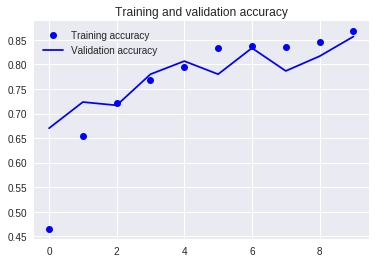

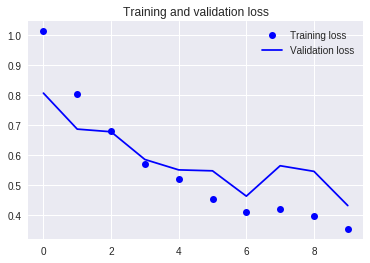

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

accuracy = history3.history['acc']
val_accuracy = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Step 8: **Classification Report


In [0]:
test_data = pd.read_csv('train_set/label.csv')

In [0]:
test_image = []
for i in tqdm(range(test.shape[0])):
    img = image.load_img('train_set/LR/'+'img_'+test_data['Image'][i], target_size=(28,28,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    test_image.append(img)
test = np.array(test_image)

100%|██████████| 1500/1500 [00:02<00:00, 590.09it/s]


In [0]:
# making predictions
prediction = cnn3.predict_classes(test)

In [0]:
# get the indices to be plotted
y_true = test_data.iloc[:, 2]
correct = np.nonzero(prediction==y_true)[0]
incorrect = np.nonzero(prediction!=y_true)[0]

In [0]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(3)]
print(classification_report(y_true, prediction, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.93      0.91      0.92       500
     Class 1       0.91      0.87      0.89       500
     Class 2       0.84      0.90      0.87       500

   micro avg       0.89      0.89      0.89      1500
   macro avg       0.89      0.89      0.89      1500
weighted avg       0.89      0.89      0.89      1500



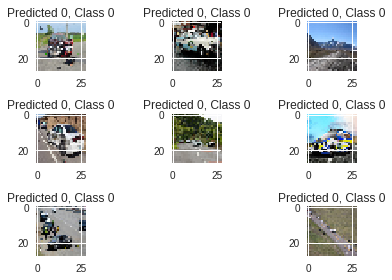

In [0]:
for i, c in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test[c].reshape(28,28,3), cmap='viridis', interpolation='none')
    plt.title("Predicted {}, Class {}".format(prediction[c], y_true[c]))
    plt.tight_layout()

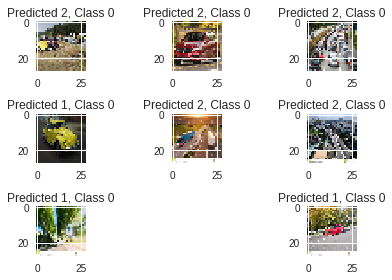

In [0]:
for i, ic in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test[ic].reshape(28,28,3), cmap='viridis', interpolation='none')
    plt.title("Predicted {}, Class {}".format(prediction[ic], y_true[ic]))
    plt.tight_layout()

In [0]:
# creating submission file
sample = pd.read_csv('label.csv')
sample['predict_label'] = prediction
print(sample[:10])
sample.to_csv('sample.csv', header=True, index=False)
from google.colab import files
files.download("sample.csv")

   Unnamed: 0     Image  Label  predict_label
0           0  0001.jpg      0              0
1           1  0002.jpg      0              0
2           2  0003.jpg      0              0
3           3  0004.jpg      0              0
4           4  0005.jpg      0              0
5           5  0006.jpg      0              0
6           6  0007.jpg      0              0
7           7  0008.jpg      0              0
8           8  0009.jpg      0              0
9           9  0010.jpg      0              0
